In [162]:
import os, shutil
from tqdm import tqdm
 
original_dataset_dir = 'CroppedYale'
 
# create a new directory for the subset of cat and dog images
base_dir = 'data'
 
# create base training, validation and test directories
def join_create_dir(base, suffix):
    """
    Join a base directory with a new folder name, creating the new
    directory and returning its path.
   
    :param base: base directory path
    :param suffix: folder to append
    """
    new_dir = os.path.join(base, suffix)
    os.mkdir(new_dir)
    return new_dir
train_dir = join_create_dir(base_dir, 'train')
validation_dir = join_create_dir(base_dir, 'validation')
test_dir = join_create_dir(base_dir, 'test')
 

# stratify these directories for cats and dogs

def split_people(base):
    """
    Stratifies a base directory into subdirectories for cats and dogs.
   
    :param base: base directory for which to create subdirectories
    """
    for i in range(1, 39):
        person_dir = os.path.join(base, 'person' + str(i))
        os.mkdir(person_dir)
   
    return person_dir
split_people(train_dir)
split_people(test_dir)
split_people(validation_dir)
 
def move_files(person, min, max, datatype):
    """
    Move a subset of images into the relavant subdir for cats or dogs.
    :param animal: cat or dog
    :param min: min image index
    :param max: max immage index
    :param datatype: train, validation or test set
    """
   
    fnames = ['{}-{}.jpg'.format(person, i) for i in range(min, max)]
#     pbar = tqdm(range(min, max), desc=f'copying {person}s')
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(f'data/{datatype}/{person}/', fname)
        shutil.copyfile(src, dst)
#         pbar.update()
#     pbar.close()   

In [163]:
for i in range(1, 39):
    move_files('person' + str(i), 1, 31, 'train')
    move_files('person' + str(i), 31, 41, 'validation')
    move_files('person' + str(i), 41, 51, 'test')

In [164]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            './data/train/',
            target_size=(168, 192),
            batch_size=3,
            class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
            './data/validation',
            target_size=(168, 192),
            batch_size=3,
            class_mode='categorical')

Found 1140 images belonging to 38 classes.
Found 380 images belonging to 38 classes.


In [165]:
from keras.applications import inception_v3

conv_base = inception_v3.InceptionV3(weights='imagenet',
                                     include_top=False,
                                     input_shape=(168, 192, 3));

In [166]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 168, 192, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 83, 95, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 83, 95, 32)   96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 83, 95, 32)   0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [167]:
conv_base.trainable = False

In [207]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook as tqdm

base_dir = '/Users/tylertarsi/Documents/ix/facial-recognition/data/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 5

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 4, 2048))
    labels = np.zeros(shape=(sample_count, 38))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(168, 192),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    pbar = tqdm(range(sample_count // batch_size - 1))
    for inputs_batch, labels_batch in generator:
        # compute features for input images in batch
        features_batch = conv_base.predict(inputs_batch)
        # store the computed features and labels in larger Numpy arr
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
        pbar.update()
    pbar.close()
    return features, labels

train_features, train_labels = extract_features(train_dir, 1140)
validation_features, validation_labels = extract_features(validation_dir, 380)
test_features, test_labels = extract_features(test_dir, 380)

Found 1140 images belonging to 38 classes.


Found 380 images belonging to 38 classes.


Found 380 images belonging to 38 classes.


In [208]:
train_features = np.reshape(train_features, (1140, 3 * 4 * 2048))
validation_features = np.reshape(validation_features, (380, 3 * 4 * 2048))
test_features = np.reshape(test_features, (380, 3 * 4 * 2048))

In [231]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=3 * 4 * 2048))
model.add(layers.Dense(38, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=5,
                    validation_data=(validation_features, validation_labels))

Train on 1140 samples, validate on 380 samples
Epoch 1/10
1140/1140 [==============================] - 29s 25ms/step - loss: 3.4991 - acc: 0.0798 - val_loss: 3.0011 - val_acc: 0.2816
Epoch 2/10
1140/1140 [==============================] - 26s 22ms/step - loss: 2.0010 - acc: 0.5202 - val_loss: 1.9410 - val_acc: 0.5605
Epoch 3/10
1140/1140 [==============================] - 27s 24ms/step - loss: 0.8451 - acc: 0.8228 - val_loss: 1.5425 - val_acc: 0.6447
Epoch 4/10
1140/1140 [==============================] - 25s 22ms/step - loss: 0.3371 - acc: 0.9412 - val_loss: 1.3549 - val_acc: 0.6921
Epoch 5/10
1140/1140 [==============================] - 26s 23ms/step - loss: 0.1508 - acc: 0.9851 - val_loss: 1.4781 - val_acc: 0.6447
Epoch 6/10
1140/1140 [==============================] - 25s 22ms/step - loss: 0.0618 - acc: 0.9956 - val_loss: 1.2354 - val_acc: 0.6947
Epoch 7/10
1140/1140 [==============================] - 24s 21ms/step - loss: 0.0336 - acc: 0.9947 - val_loss: 1.2461 - val_acc: 0.7263
E

In [232]:
test_loss, test_acc = model.evaluate(test_features, test_labels)

380/380 [==============================] - 0s 504us/step


In [233]:
test_loss

1.2142069515429046

In [234]:
test_acc

0.7236842124085677

## Training and Validation Visualizations

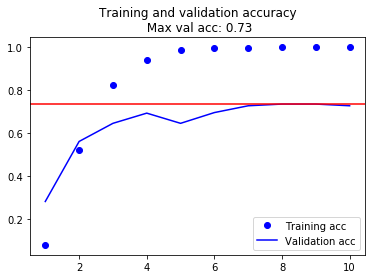

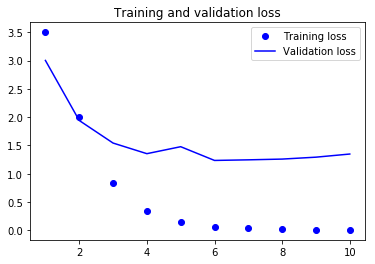

In [237]:
%matplotlib inline
from utils import show_plots
show_plots(history.history['acc'],
           history.history['val_acc'],
           history.history['loss'],
           history.history['val_loss'])

## Random Classifier

In [239]:
from random import randint
def pick():
    correct = 0
    incorrect = 0
    for person in range(0, 380):
        i = randint(0,37)
        if test_labels[person,i] == 1:
            correct += 1
        else:
            incorrect += 1
    return correct / (correct + incorrect)

In [247]:
avg = 0
trials = 50
for i in range(0, trials):
    avg += pick()
avg/trials

0.025842105263157892